In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# generate synthetic data

x = [0.1]
y = [0.2]
for _ in range(10):
    new_x = x[-1] * (3.78 - 3.78 * x[-1])
    new_y = y[-1] * (3.77 - 3.77 * y[-1])
    x.append(new_x)
    y.append(new_y)

# for _ in range(2000000):
for _ in range(20000):
    new_x = x[-1] * (3.78 - 3.78 * x[-1])
    new_y = y[-1] * (3.77 - 3.77 * y[-1] - 0.8 * x[-10])
    x.append(new_x)
    y.append(new_y)

In [3]:
# plt.figure(figsize=(22, 6))

# plt.plot(x[:300])
# plt.plot(y[:300])

In [4]:
# plt.figure(figsize=(12, 12))

# # plt.plot(x[:300], y[:300], linewidth=0.3)
# plt.scatter(x, y, s=0.05)

In [5]:
# # correlation
# np.corrcoef(x, y)[0, 1]

# Reservoir computing

In [6]:
from pyrcn.echo_state_network import ESNRegressor

In [7]:
# reg = ESNRegressor(n_readout=1, n_components=1000, spectral_radius=0.9, random_state=42)
reg = ESNRegressor(hidden_layer_size=500)

In [8]:
# # lag the x time series
# lag = 10
# x = x[:-lag]
# y = y[lag:]

In [9]:
train_len = int(len(x) * 0.6)
X_train = np.array(x[:train_len]).reshape(-1, 1)
X_test = np.array(x[train_len:]).reshape(-1, 1)
y_train = np.array(y[:train_len])
y_test = np.array(y[train_len:])

In [10]:
reg.fit(X=X_train, y=y_train)

ESNRegressor(input_to_node=InputToNode(), node_to_node=NodeToNode(),
             regressor=IncrementalRegression(), requires_sequence=False)

In [11]:
y_pred = reg.predict(X_test)

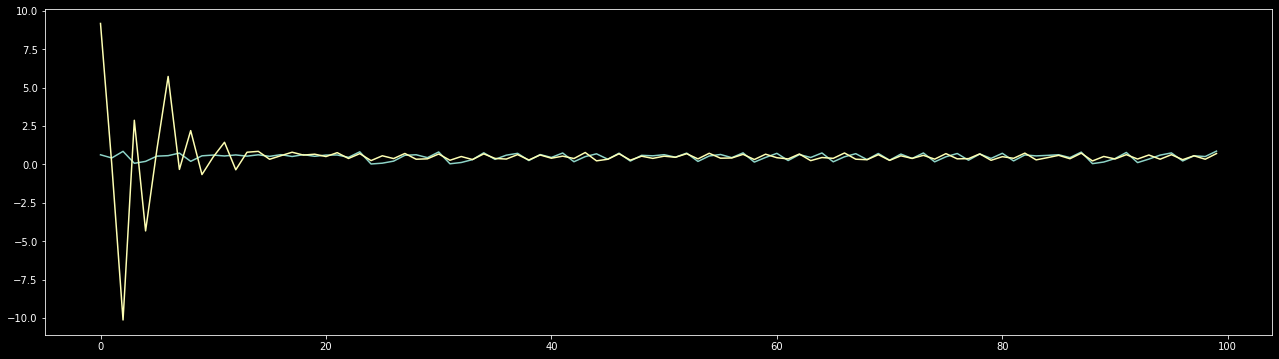

In [12]:
plt.figure(figsize=(22, 6))
# plt.ylim(-1, 1)

plt.plot(y_test[:100])
plt.plot(y_pred[:100])
# plt.plot(y_test[100:])
# plt.plot(y_pred[100:])

In [13]:
# correlation
np.corrcoef(y_test[100:], y_pred[100:])[0, 1]

0.6592247160652025

In [14]:
# correlation on trianing set
y_pred_train = reg.predict(X_train)
np.corrcoef(y_train, y_pred_train)[0, 1]

0.6864523154243054

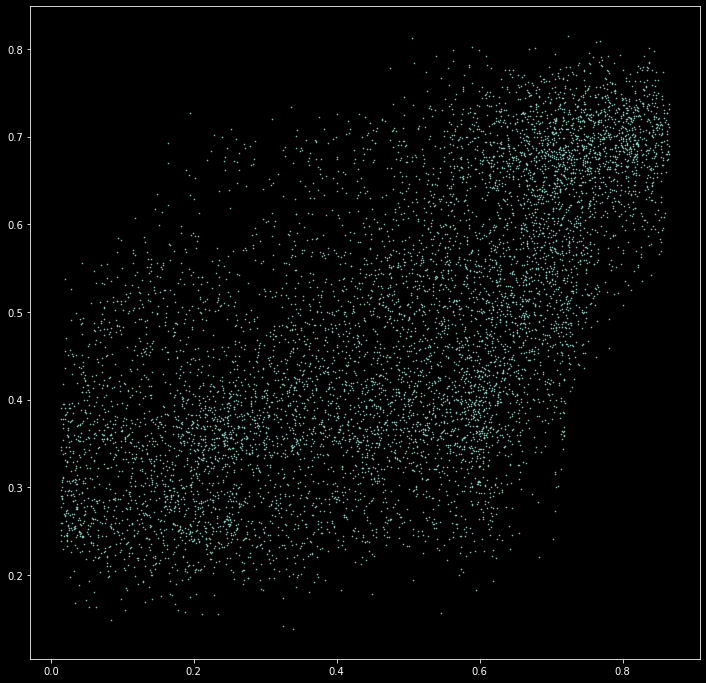

In [15]:
# scatter plot
plt.figure(figsize=(12, 12))
plt.scatter(y_test[100:], y_pred[100:], s=0.3)

In [16]:
reg.get_params()

{'bias_scaling': 1.0,
 'bias_shift': 0.0,
 'hidden_layer_size': 500,
 'input_activation': 'tanh',
 'input_scaling': 1.0,
 'input_shift': 0.0,
 'k_in': None,
 'predefined_bias_weights': None,
 'predefined_input_weights': None,
 'random_state': 42,
 'sparsity': 1.0,
 'bidirectional': False,
 'k_rec': None,
 'leakage': 1.0,
 'predefined_recurrent_weights': None,
 'reservoir_activation': 'tanh',
 'spectral_radius': 1.0,
 'alpha': 1e-05}

In [20]:
X_test.shape

(8005, 1)

In [19]:
reg.hidden_layer_state(X_test).shape

(8005, 500)